In [1]:
import numpy as np
import glob
import datetime as dt
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import cartopy
from skimage.morphology import dilation, square, closing
from collections import defaultdict
import pandas as pd
from pynextsim.gridding import Grid
import pynextsim.lib as nsl

import mod_netcdf_utils as mnu

from compare_rs2_moorings import(
    get_arg_parser,
    read_rs2_file,
    compare,
    NS_PROJ,
    TrajectoryGenerator,
)

In [2]:
def test_time_iterator(tg, dto1, dto2):
    t1 = dto1
    for i, dt_ in tg.time_iterator(dto1, dto2):
        t2 = t1 + dt.timedelta(seconds=dt_)
        print(i, tg.nci.datetimes[i], t1, t2, sep=' | ')
        t1 = t2

In [3]:
def filter_pm_results(pm_results, delta_t):
    delta_t = (dto2_ -  dto1_).total_seconds()
    lm = (pm_results['water_mask'] != 1).astype(int)
    lm = dilation(lm, square(5)).astype(bool) # extend land mask by 5 pixels
    spd = np.hypot(pm_results['upm_clean'], pm_results['vpm_clean'])/delta_t
    gpi = (~lm)*np.isfinite(spd)*(spd < .5)
    print(spd.shape, gpi.shape)
    xy1 = NS_PROJ.pyproj(pm_results['lon1pm'][gpi], pm_results['lat1pm'][gpi])
    return xy1, gpi

In [4]:
def get_deformation_percentile(x, y, u, v, perc):
    e1, e2, e3, a, p, t = nsl.get_deformation_nodes(x, y, u, v)
    e1 *= 8640000
    e2 *= 8640000
    e3 *= 8640000
    amin, amax = np.percentile(a, [10,90])
    gpi = (a<=amax)*(a>=amin)
    if np.sum(gpi) > 0:
        return np.percentile(e3[gpi], perc)
    try:
        return np.full((len(perc),), np.nan)
    except:
        return np.nan

In [5]:
def get_daily_average_sic(nci, dto, ij_range=None):
    d = dto.toordinal()
    indices = [i for i,dto_i in enumerate(nci.datetimes) if dto_i.toordinal()==d]
    sic_av = 0
    for i in indices:
        sic_av += nci.get_var('sic', time_index=i, ij_range=ij_range).values.filled(np.nan)
    return sic_av/len(indices)

In [6]:
mfil = '/docker_io/arktalas/Moorings.nc'
rfil = 'out/drift-defor/npz_files/pm_20130224T023841Z-20130225T020927Z_21.npz' #'/docker_io/arktalas/pm_20130224T023841Z-20130225T020927Z_21.npz'
args = get_arg_parser().parse_args([rfil, mfil, 'comp_rs2_moorings'])
print(vars(args))

{'rs2_dir': 'out/drift-defor/npz_files/pm_20130224T023841Z-20130225T020927Z_21.npz', 'moorings_file': '/docker_io/arktalas/Moorings.nc', 'outdir': 'comp_rs2_moorings', 'test': False, 'force': False}


In [7]:
dto1, dto2, pm_results, xy1, gpi_rs2 = read_rs2_file(rfil)
nci = mnu.nc_getinfo(mfil)
tg = TrajectoryGenerator(nci, NS_PROJ, xy1, expansion_factor=3)
tg0 = TrajectoryGenerator(nci, NS_PROJ, xy1, expansion_factor=1.1)
grid = tg.get_grid()
grid0 = tg0.get_grid()

Reading                 : out/drift-defor/npz_files/pm_20130224T023841Z-20130225T020927Z_21.npz
Start                   : 2013-02-24 02:38:41
End                     : 2013-02-25 02:09:27
Interval                : 23:30:46
Number of drift vectors : 4214


In [8]:
for k,v in pm_results.items():
    print(k, v.shape)

lon1pm (91, 111)
lat1pm (91, 111)
water_mask (91, 111)
upm (91, 111)
vpm (91, 111)
apm (91, 111)
rpm (91, 111)
hpm (91, 111)
lon2pm (91, 111)
lat2pm (91, 111)
upm_clean (91, 111)
vpm_clean (91, 111)


## Check `time_iterator`

In [9]:
test_time_iterator(tg, dto1, dto2)

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00
89 | 2013-02-24 04:30:00 | 2013-02-24 03:00:00 | 2013-02-24 06:00:00
90 | 2013-02-24 07:30:00 | 2013-02-24 06:00:00 | 2013-02-24 09:00:00
91 | 2013-02-24 10:30:00 | 2013-02-24 09:00:00 | 2013-02-24 12:00:00
92 | 2013-02-24 13:30:00 | 2013-02-24 12:00:00 | 2013-02-24 15:00:00
93 | 2013-02-24 16:30:00 | 2013-02-24 15:00:00 | 2013-02-24 18:00:00
94 | 2013-02-24 19:30:00 | 2013-02-24 18:00:00 | 2013-02-24 21:00:00
95 | 2013-02-24 22:30:00 | 2013-02-24 21:00:00 | 2013-02-25 00:00:00
96 | 2013-02-25 01:30:00 | 2013-02-25 00:00:00 | 2013-02-25 02:09:27


In [10]:
test_time_iterator(tg, dto1, dto1 + dt.timedelta(minutes=1))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 02:39:41


In [11]:
test_time_iterator(tg, dto1, dt.datetime(2013,2,24,3))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00


In [12]:
test_time_iterator(tg, dto1, dt.datetime(2013,2,24,3,1))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00
89 | 2013-02-24 04:30:00 | 2013-02-24 03:00:00 | 2013-02-24 03:01:00


## Check interpolation
Interpolate onto in-between grid points

In [13]:
i0, i1, j0, j1 = tg.ij_range
x_target = .5*(tg.x[1:] + tg.x[:-1])
y_target = .5*(tg.y[1:] + tg.y[:-1])
x_target, y_target = np.meshgrid(x_target, y_target)
shp = x_target.shape
dst_p = np.array([y_target.flatten(), x_target.flatten()]).T
grid2 = Grid(x_target, y_target, projection=NS_PROJ)

Text(0.5, 1.0, 'u, m/s')

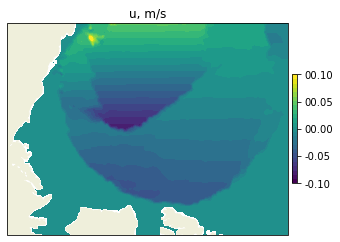

In [14]:
time_index = 88
idata = dict(
    siu=tg.nci.get_var('siu', time_index=time_index, ij_range=tg.ij_range).values.filled(np.nan),
    siv=tg.nci.get_var('siv', time_index=time_index, ij_range=tg.ij_range).values.filled(np.nan),
    )
idata = tg.get_interpolated_vars(idata, dst_p)
fix, ax = grid2.plot(idata['siu'].reshape(shp), cmap='viridis', clim=[-.1,.1])
ax.set_title('u, m/s')

Actual data

In [15]:
data = []
masks = []
for time_index in [88, 96]:
    data += [{
        k : tg.nci.get_var(k, ij_range=tg.ij_range, time_index=time_index).values
        for k in ['sic', 'sit', 'siu', 'siv']
        }]
    masks += [data[-1]['sic'] < .15 ]
    for k in ['siu', 'siv']:
        data[-1][k][masks[-1]] = np.nan

Text(0.5, 1.0, 'v, m/s')

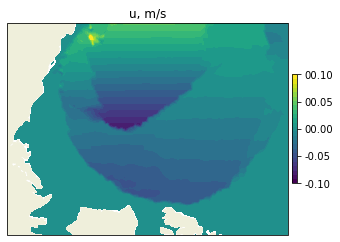

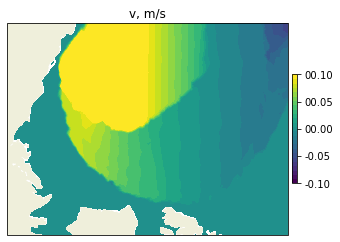

In [16]:
fig, ax = grid.plot(data[0]['siu'], cmap='viridis', clim=[-.1,.1])
ax.set_title('u, m/s')
fig, ax = grid.plot(data[0]['siv'], cmap='viridis', clim=[-.1,.1])
ax.set_title('v, m/s')

## Radarsat2 drift

In [17]:
igi = grid.get_interpolator((pm_results['lon1pm'], pm_results['lat1pm']),
                            latlon=True, interp_from=False)

Projecting external points
Triangulating external points and matching to grid points


Text(0.5, 1.0, 'v, m/s')

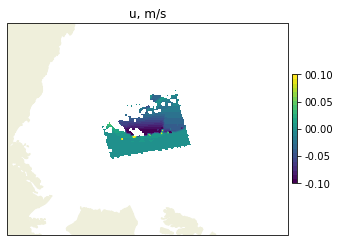

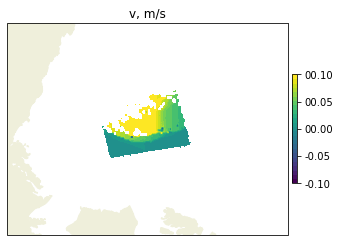

In [18]:
delta_t = (dto2 - dto1).total_seconds()
u_rs2 = igi.interp_field(pm_results['upm_clean']/delta_t)
fig, ax = grid.plot(u_rs2, cmap='viridis', clim=[-.1, .1])
ax.set_title('u, m/s')
# # add model ice edge
# grid.add_contour(ax, data[0]['sic'], levels=[.15], colors='m') #initial edge
# grid.add_contour(ax, data[1]['sic'], levels=[.15], colors='k') #final edge

v_rs2 = igi.interp_field(pm_results['vpm_clean']/delta_t)
fig, ax = grid.plot(v_rs2, cmap='viridis', clim=[-.1, .1])
ax.set_title('v, m/s')
# # add model ice edge
# grid.add_contour(ax, data[0]['sic'], levels=[.15], colors='m') #initial edge
# grid.add_contour(ax, data[1]['sic'], levels=[.15], colors='k') #final edge

## Integrate neXtSIM velocities to give corresponding drift to the Radarsat 2

In [19]:
xt, yt, dtimes, time_indices, sic_av = tg0.integrate_velocities(*xy1, dto1, dto2)
dx_mod = xt[:,-1] - xt[:,0]
dy_mod = yt[:,-1] - yt[:,0]

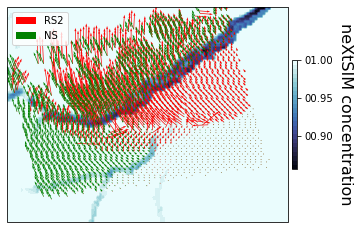

In [20]:
fig, ax = grid0.plot(sic_av, clabel='neXtSIM concentration')
s = slice(None, None, 2) #plot every 2nd vector
xp = xy1[0][s]
yp = xy1[1][s]
dx_obs = pm_results['upm_clean'][gpi_rs2]
dy_obs = pm_results['vpm_clean'][gpi_rs2]
ax.quiver(xp, yp, dx_obs[s], dy_obs[s],
          color='r', units='xy', scale=.5, label='RS2')
ax.quiver(xp, yp, dx_mod[s], dy_mod[s], color='g', units='xy', scale=.5, label='NS')#, scale='xy')
ax.legend()

In [21]:
errors = compare(dx_mod, dy_mod,
        pm_results['upm_clean'][gpi_rs2], pm_results['vpm_clean'][gpi_rs2],
        delta_t)

Bias in speed = 2.052587499099058 km/day
RMSE in speed = 5.945360959220301 km/day
VMRSE = 6.543048178032359 km/day


/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1763: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


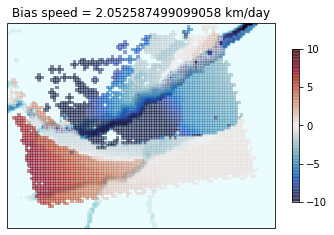

In [22]:
unit_fac = 1e-3*24*3600/delta_t #m -> km/day
spd_diff = np.full_like(pm_results['lon1pm'], np.nan) #m
spd_diff[gpi_rs2] = (
    np.hypot(dx_mod, dy_mod)
    - np.hypot(pm_results['upm_clean'][gpi_rs2], pm_results['vpm_clean'][gpi_rs2])
    )
fig, ax = grid0.plot(sic_av, add_colorbar=False)
x1pm, y1pm = NS_PROJ.pyproj(pm_results['lon1pm'], pm_results['lat1pm'])
spd_diff *= unit_fac #km/day
im = ax.pcolor(x1pm, y1pm, spd_diff, cmap='balance',
               shading='auto', vmin=-10, vmax=10, alpha=0.5)
ax.set_title(f"Bias speed = {errors['bias_speed']} km/day")
fig.colorbar(im, shrink=0.7)

/opt/conda/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1763: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


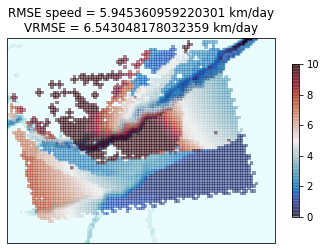

In [23]:
vdiff = np.full_like(pm_results['lon1pm'], np.nan) #m
vdiff[gpi_rs2] = np.hypot(
    dx_mod - pm_results['upm_clean'][gpi_rs2],
    dy_mod - pm_results['vpm_clean'][gpi_rs2],
    )
fig, ax = grid0.plot(sic_av, add_colorbar=False)
vdiff *= unit_fac #km/day
im = ax.pcolor(x1pm, y1pm, vdiff,
               cmap='balance', shading='auto', vmin=0, vmax=10, alpha=0.5)
ax.set_title(f"RMSE speed = {errors['rmse_speed']} km/day\nVRMSE = {errors['vrmse']} km/day")
fig.colorbar(im, shrink=0.7)

Text(0.5, 1.0, 'r = -0.012651436782462291')

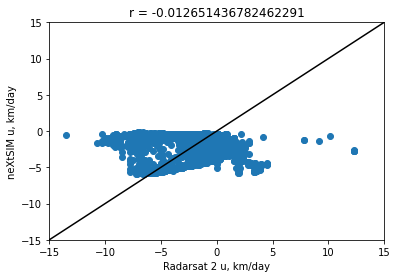

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
uo = pm_results['upm_clean'][gpi_rs2]*unit_fac
inds = np.argsort(uo)
uo = uo[inds]
um = dx_mod[inds]*unit_fac
gpi = np.isfinite(uo*um)

ax.plot(uo, uo, 'k')
ax.scatter(uo, um)
ax.set_xlabel('Radarsat 2 u, km/day')
ax.set_ylabel('neXtSIM u, km/day')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_title(f'r = {pearsonr(uo[gpi], um[gpi])[0]}')

Text(0.5, 1.0, 'r = 0.6002104327273433')

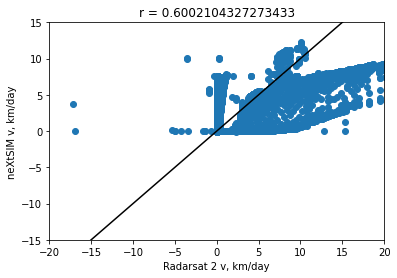

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
vo = pm_results['vpm_clean'][gpi_rs2]*unit_fac
inds = np.argsort(vo)
vo = vo[inds]
vm = dy_mod[inds]*unit_fac
gpi = np.isfinite(vo*vm)

ax.plot(vo, vo, 'k')
ax.scatter(vo, vm)
ax.set_xlabel('Radarsat 2 v, km/day')
ax.set_ylabel('neXtSIM v, km/day')
ax.set_xlim([-20,20])
ax.set_ylim([-15,15])
ax.set_title(f'r = {pearsonr(vo[gpi], vm[gpi])[0]}')

## Transect

In [26]:
nci = mnu.nc_getinfo(mfil)
ij_range = [0,550,0,250]
mlon, mlat = nci.get_lonlat(ij_range=ij_range)
mgrid = Grid(mlon, mlat, latlon=True)
xtr, ytr = [a[180:450,100] for a in mgrid.xy]

ij_range:  [0, 550, 0, 250]


In [27]:
sic_av_all = 0
for i, _ in tg.time_iterator(dto1, dto2):
    sic_av_all += nci.get_var('sic', time_index=i, ij_range=ij_range).values.filled(np.nan)
sic_av_all /= i

In [28]:
plot_files = sorted(glob.glob('out/drift-defor/npz_files/hh_*.npz'))
pm_files = sorted(glob.glob('out/drift-defor/npz_files/pm_*.npz'))

In [29]:
df = defaultdict(list)
for pm_file in pm_files:
    dto1_, dto2_, res, _, _ = read_rs2_file(pm_file)
    delta_t = (dto2_ -  dto1_).total_seconds()
    
    # filter out too-high drift and points to close to the coast
    (x1_, y1_), gpi_ = filter_pm_results(res, delta_t)
    df['mean_date'] += [dto1_ + dt.timedelta(seconds=.5*delta_t)]
    df['delta_t'] += [delta_t]
    df['mean_x'] += [np.mean(x1_)]
    df['mean_y'] += [np.mean(y1_)]
    
    # speed
    u_ = res['upm_clean'][gpi_]/delta_t
    v_ = res['vpm_clean'][gpi_]/delta_t
    df['mean_square_spd'] += [np.sqrt(np.mean(np.hypot(u_, v_)**2))]

    # deformation
    df['p80_defor'] += [get_deformation_percentile(x1_, y1_, u_, v_, 80)] #80th percentile
    
#     # compare drift - need trajectory generation inside the loop
#     errors_ = compare(dx_mod, dy_mod,
#         res['upm_clean'][gpi_rs2], res['vpm_clean'][gpi_rs2],
#         delta_t)
#     for k,v in errors.items():
#         df[k] += [v]
df = pd.DataFrame(df).set_index('mean_date')

Reading                 : out/drift-defor/npz_files/pm_20130220T144616Z-20130223T145936Z_0.npz
Start                   : 2013-02-20 14:46:16
End                     : 2013-02-23 14:59:36
Interval                : 3 days, 0:13:20
Number of drift vectors : 2541
(99, 47) (99, 47)
Reading                 : out/drift-defor/npz_files/pm_20130220T144730Z-20130223T145936Z_1.npz
Start                   : 2013-02-20 14:47:30
End                     : 2013-02-23 14:59:36
Interval                : 3 days, 0:12:06
Number of drift vectors : 1796
(98, 34) (98, 34)
Reading                 : out/drift-defor/npz_files/pm_20130223T145936Z-20130224T005815Z_2.npz
Start                   : 2013-02-23 14:59:36
End                     : 2013-02-24 00:58:15
Interval                : 9:58:39
Number of drift vectors : 4184
(112, 94) (112, 94)
Reading                 : out/drift-defor/npz_files/pm_20130223T145936Z-20130224T143020Z_3.npz
Start                   : 2013-02-23 14:59:36
End                     : 2013-

/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: invalid value encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsi

Number of drift vectors : 3796
(98, 66) (98, 66)
Reading                 : out/drift-defor/npz_files/pm_20130223T150134Z-20130225T020807Z_7.npz
Start                   : 2013-02-23 15:01:34
End                     : 2013-02-25 02:08:07
Interval                : 1 day, 11:06:33
Number of drift vectors : 3526
(75, 103) (75, 103)
Reading                 : out/drift-defor/npz_files/pm_20130223T150134Z-20130226T151426Z_8.npz
Start                   : 2013-02-23 15:01:34
End                     : 2013-02-26 15:14:26
Interval                : 3 days, 0:12:52
Number of drift vectors : 4221
(96, 82) (96, 82)
Reading                 : out/drift-defor/npz_files/pm_20130223T164114Z-20130224T023841Z_9.npz
Start                   : 2013-02-23 16:41:14
End                     : 2013-02-24 02:38:41
Interval                : 9:57:27
Number of drift vectors : 4571
(114, 109) (114, 109)
Reading                 : out/drift-defor/npz_files/pm_20130223T164114Z-20130224T161204Z_10.npz
Start                  

/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in add
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: invalid value encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-too

Reading                 : out/drift-defor/npz_files/pm_20130223T164114Z-20130225T020927Z_12.npz
Start                   : 2013-02-23 16:41:14
End                     : 2013-02-25 02:09:27
Interval                : 1 day, 9:28:13
Number of drift vectors : 1698
(82, 108) (82, 108)
Reading                 : out/drift-defor/npz_files/pm_20130223T164228Z-20130224T161230Z_13.npz
Start                   : 2013-02-23 16:42:28
End                     : 2013-02-24 16:12:30
Interval                : 23:30:02
Number of drift vectors : 1147
(73, 65) (73, 65)
Reading                 : out/drift-defor/npz_files/pm_20130223T164228Z-20130225T034909Z_14.npz
Start                   : 2013-02-23 16:42:28
End                     : 2013-02-25 03:49:09
Interval                : 1 day, 11:06:41
Number of drift vectors : 467
(60, 68) (60, 68)
Reading                 : out/drift-defor/npz_files/pm_20130224T005724Z-20130226T151312Z_15.npz
Start                   : 2013-02-24 00:57:24
End                     : 20

/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in add
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in add
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:987: RuntimeWarning: invalid value encountered in sqrt
  tri_a = np.sqrt(s * (s - tri_s[0]) * (s - tr

Reading                 : out/drift-defor/npz_files/pm_20130224T143020Z-20130225T002923Z_22.npz
Start                   : 2013-02-24 14:30:20
End                     : 2013-02-25 00:29:23
Interval                : 9:59:03
Number of drift vectors : 5489
(110, 110) (110, 110)
Reading                 : out/drift-defor/npz_files/pm_20130224T143020Z-20130227T144217Z_23.npz
Start                   : 2013-02-24 14:30:20
End                     : 2013-02-27 14:42:17
Interval                : 3 days, 0:11:57
Number of drift vectors : 3815
(100, 67) (100, 67)
Reading                 : out/drift-defor/npz_files/pm_20130224T161050Z-20130225T020927Z_24.npz
Start                   : 2013-02-24 16:10:50
End                     : 2013-02-25 02:09:27
Interval                : 9:58:37
Number of drift vectors : 3068
(112, 78) (112, 78)
Reading                 : out/drift-defor/npz_files/pm_20130224T161050Z-20130225T020954Z_25.npz
Start                   : 2013-02-24 16:10:50
End                     : 201

/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in add
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynex

Number of drift vectors : 2559
(110, 73) (110, 73)
Reading                 : out/drift-defor/npz_files/pm_20130224T175335Z-20130225T034909Z_27.npz
Start                   : 2013-02-24 17:53:35
End                     : 2013-02-25 03:49:09
Interval                : 9:55:34
Number of drift vectors : 1199
(76, 109) (76, 109)
Reading                 : out/drift-defor/npz_files/pm_20130225T002923Z-20130227T144217Z_28.npz
Start                   : 2013-02-25 00:29:23
End                     : 2013-02-27 14:42:17
Interval                : 2 days, 14:12:54
Number of drift vectors : 4438
(111, 90) (111, 90)
Reading                 : out/drift-defor/npz_files/pm_20130225T020807Z-20130226T151426Z_29.npz
Start                   : 2013-02-25 02:08:07
End                     : 2013-02-26 15:14:26
Interval                : 1 day, 13:06:19
Number of drift vectors : 4796
(103, 104) (103, 104)


/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in subtract
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:937: RuntimeWarning: invalid value encountered in add
  e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: divide by zero encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:933: RuntimeWarning: invalid value encountered in true_divide
  ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]
/nextsim-tools/python/pynextsim/lib.py:936: RuntimeWarning: invalid value encountered in add
  e1 = ux + vy
/nextsim-too

In [30]:
df

,delta_t,mean_x,mean_y,mean_square_spd,p80_defor
mean_date,,,,,
2013-02-22 02:52:56.000,260000.0,-1.099603e+06,-388827.519380,0.001290,0.000145
2013-02-22 02:53:33.000,259926.0,-1.224281e+06,-393670.253651,0.000361,0.314148
2013-02-23 19:58:55.500,35919.0,-1.315923e+06,-316107.473035,0.005078,2.987147
2013-02-24 02:44:58.000,84644.0,-1.155431e+06,-476129.835312,0.000779,0.000478
2013-02-24 07:44:29.500,120587.0,-1.173443e+06,-394276.722090,0.000453,0.807036
2013-02-23 19:59:07.500,35793.0,-1.556475e+06,-485000.000000,0.004644,2.988412
2013-02-25 03:07:01.500,259941.0,-1.567777e+06,-280547.682880,0.000390,0.444933
2013-02-24 08:34:50.500,126393.0,-1.925969e+06,-208069.326884,0.004413,0.897018
2013-02-25 03:08:00.000,259972.0,-1.983380e+06,-270749.577703,0.000503,0.497352


Text(0.5, 1.0, 'Pairs and 80th deformation percentile (%/day)')

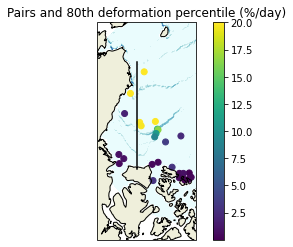

In [31]:
fig, ax = mgrid.plot(sic_av_all, add_colorbar=False)
ax.coastlines()
ax.plot(xtr, ytr, 'k')
sc = ax.scatter(df['mean_x'], df['mean_y'], c=df['p80_defor'], vmax=20)
fig.colorbar(sc)
ax.set_title('Pairs and 80th deformation percentile (%/day)')

Text(0.5, 1.0, 'Pairs and MS speed (m/s)')

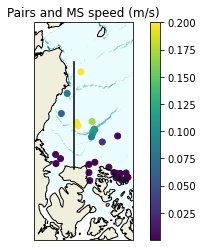

In [32]:
fig, ax = mgrid.plot(sic_av_all, add_colorbar=False)
ax.coastlines()
ax.plot(xtr, ytr, 'k')
sc = ax.scatter(df['mean_x'], df['mean_y'], c=df['mean_square_spd'], vmax=.2)
fig.colorbar(sc)
ax.set_title('Pairs and MS speed (m/s)')

## Split by date

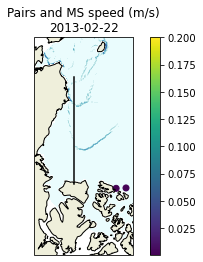

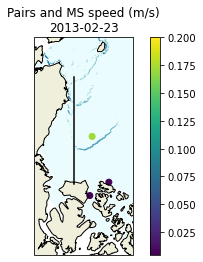

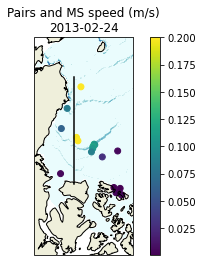

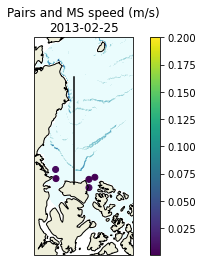

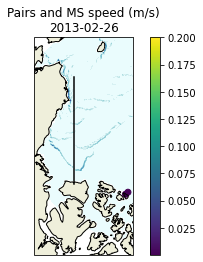

In [33]:
for date, df_ in df.groupby(pd.Grouper(freq='D')):
    sic_av_ = get_daily_average_sic(nci, date, ij_range=ij_range)
    fig, ax = mgrid.plot(sic_av_, add_colorbar=False)
    ax.coastlines()
    ax.plot(xtr, ytr, 'k')
    sc = ax.scatter(df_['mean_x'], df_['mean_y'], c=df_['mean_square_spd'], vmax=.2)
    fig.colorbar(sc)
    ax.set_title(f"Pairs and MS speed (m/s)\n{date.strftime('%Y-%m-%d')}")
    plt.show()

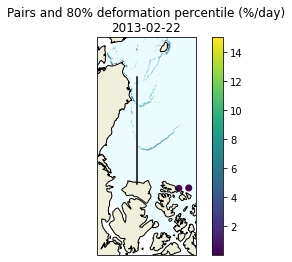

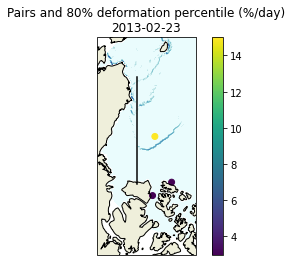

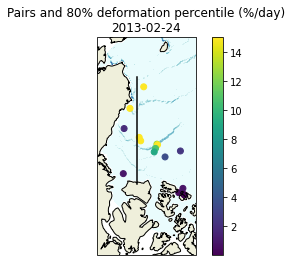

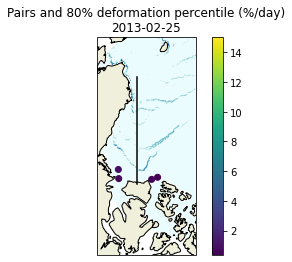

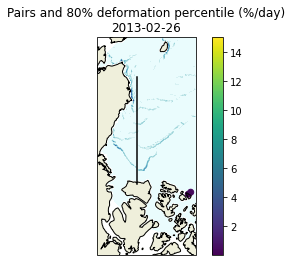

In [34]:
for date, df_ in df.groupby(pd.Grouper(freq='D')):
    sic_av_ = get_daily_average_sic(nci, date, ij_range=ij_range)
    fig, ax = mgrid.plot(sic_av_, add_colorbar=False)
    ax.coastlines()
    ax.plot(xtr, ytr, 'k')
    sc = ax.scatter(df_['mean_x'], df_['mean_y'], c=df_['p80_defor'], vmax=15)
    fig.colorbar(sc)
    ax.set_title(f"Pairs and 80% deformation percentile (%/day)\n{date.strftime('%Y-%m-%d')}")
    plt.show()

## Havmoeller plot

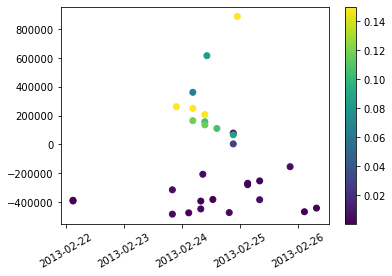

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_tick_params(rotation=30)
sc = ax.scatter(df.index, df['mean_y'], c=df['mean_square_spd'], vmax=.15)
fig.colorbar(sc)